**LATIHAN MEMBUAT MODEL ML DENGAN ALGORITMA CNN V.02**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Menyiapkan direktori

In [ ]:
base_dir = '/content/drive/MyDrive/SKRIPSI/Dataset/wayang2'
!ls '/content/drive/MyDrive/SKRIPSI/Dataset/wayang2'

bahan  latih  validasi


In [ ]:
# menentukan direktori
import os
bahan_dir = os.path.join(base_dir, 'bahan')
train_dir = os.path.join(base_dir, 'latih')
validation_dir = os.path.join(base_dir, 'validasi')

# menentukan direktori isi bahan
antagonis_dir = os.path.join(bahan_dir, 'antagonis/')
protagonis_dir = os.path.join(bahan_dir, 'protagonis/')

# cetak
print("Jumlah data latih tiap kelas:")
print("Jumlah tokoh wayang antagonis: ", len(os.listdir(antagonis_dir)))
print("Jumlah tokoh wayang protagonis: ", len(os.listdir(protagonis_dir)))

Jumlah data latih tiap kelas:
Jumlah tokoh wayang antagonis:  110
Jumlah tokoh wayang protagonis:  110


In [ ]:
# Direktori isi latih/training
train_antagonis = os.path.join(train_dir, 'antagonis/')
train_protagonis = os.path.join(train_dir, 'protagonis/')

# Direktori isi validasi
validation_antagonis = os.path.join(validation_dir, 'antagonis/')
validation_protagonis = os.path.join(validation_dir, 'protagonis/')

Menyiapkan dataset

In [ ]:
import random
from shutil import copyfile

def train_val_split(source, train, val, train_ratio):
  total_size = len(os.listdir(source))
  train_size = int(train_ratio*total_size)
  val_size = total_size - train_size

  randomized = random.sample(os.listdir(source), total_size)
  train_files = randomized[0:train_size]
  val_files = randomized[train_size:total_size]

  # loop
  for i in train_files:
    i_file = source + i
    destination = train + i
    copyfile(i_file, destination)

  for i in val_files:
    i_file = source + i
    destination = val + i
    copyfile(i_file, destination)

# Pembagian jumlah data latih dan uji 80:20 %
train_ratio = 0.8

# Pembagian training dan validasi
source_00 = antagonis_dir
train_00 = train_antagonis
val_00 = validation_antagonis
train_val_split(source_00, train_00, val_00, train_ratio)

source_01 = protagonis_dir
train_01 = train_protagonis
val_01 = validation_protagonis
train_val_split(source_01, train_01, val_01, train_ratio)

In [ ]:
# Cetak hasil spliting data latih dari sumber data
print("Jumlah tokoh wayang antagonis: ", len(os.listdir(antagonis_dir)))
print("Jumlah data latih tokoh wayang antagonis: ", len(os.listdir(train_antagonis)))
print("Jumlah tokoh wayang protagonis: ", len(os.listdir(protagonis_dir)))
print("Jumlah data latih tokoh wayang protagonis: ", len(os.listdir(train_protagonis)))

Jumlah tokoh wayang antagonis:  110
Jumlah data latih tokoh wayang antagonis:  88
Jumlah tokoh wayang protagonis:  110
Jumlah data latih tokoh wayang protagonis:  88


Pre-Processing Data using Tensorflow - Keras

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# lakukan preprocessing data image
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.1
)

In [ ]:
# Target
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size =(150,150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size =(150,150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 176 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [ ]:
# CallBack
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.99):
      print("\nAkurasi sudah mencapai 99%")
      self.model.stop_training = True

callbacks = myCallback()

**Model CNN**

In [ ]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(200, activation='relu'),
      tf.keras.layers.Dropout(0.3, seed=112),
      tf.keras.layers.Dense(500, activation='relu'),
      tf.keras.layers.Dropout(0.5, seed=112),
      tf.keras.layers.Dense(2, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=25,
    validation_data = val_generator,
    validation_steps = 1,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
6/6 [==============================] - 4s 460ms/step - loss: 0.7174 - accuracy: 0.4643 - val_loss: 0.6870 - val_accuracy: 0.6000
Epoch 2/25
6/6 [==============================] - 2s 403ms/step - loss: 0.6835 - accuracy: 0.5357 - val_loss: 0.7124 - val_accuracy: 0.4000
Epoch 3/25
6/6 [==============================] - 3s 427ms/step - loss: 0.7080 - accuracy: 0.4667 - val_loss: 0.6705 - val_accuracy: 0.8000
Epoch 4/25
6/6 [==============================] - 2s 398ms/step - loss: 0.6954 - accuracy: 0.5333 - val_loss: 0.7122 - val_accuracy: 0.2000
Epoch 5/25
6/6 [==============================] - 2s 429ms/step - loss: 0.6880 - accuracy: 0.5714 - val_loss: 0.6029 - val_accuracy: 0.9000
Epoch 6/25
6/6 [==============================] - 2s 408ms/step - loss: 0.6858 - accuracy: 0.6167 - val_loss: 0.6680 - val_accuracy: 0.7000
Epoch 7/25
6/6 [==============================] - 3s 408ms/step - loss: 0.6598 - accuracy: 0.6667 - val_loss: 0.8749 - val_accuracy: 0.3000
Epoch 8/25
6/6 [====

**Tingkat akurasi dan loss model**

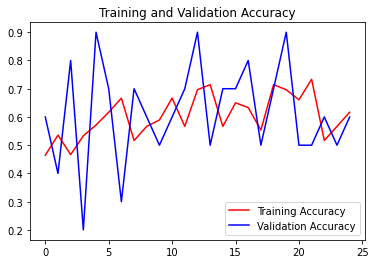

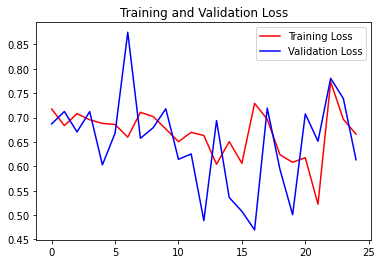

In [ ]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc = 'best')
plt.show()

print("\n")

plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend(loc = 'best')
plt.show()

**Mencoba Klasifikasi dengan Image Baru**

Saving testing.jpg to testing (8).jpg
[[1.000000e+00 8.580821e-09]]


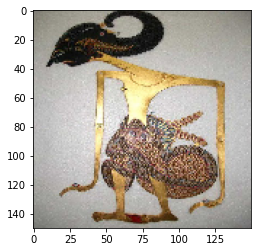

In [44]:
import numpy as np
from keras.preprocessing import  image
from google.colab import files

unggahan = files.upload()

for fn in unggahan.keys():
  # prediksi image
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=100)
  # print(classes)
  print(fn)

  # masih belum paham di sini (pelajari lagi!)
  class_list = os.listdir(train_dir)

  for j in range(80):
    if classes[0][j] == 1. :
      print("\nTokoh wayang ini berkarakter ", class_list[j])
    elif classes[0][j] != 1 :
      print("\nTokoh wayang ini berkarakter ", class_list[j-1])
    break